In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [76]:
from src.utils import StyledMNISTGenerator, StyledMNIST
from corruption_utils import corruptions

train = torchvision.datasets.MNIST(
    "../data", train=True, download=True, transform=transforms.ToTensor()
)
# mnist = torchvision.datasets.MNIST("../data", train=True, download=True)
# generator = StyledMNISTGenerator(
#     mnist,
#     {
#         corruptions.identity: 0.1,
#         corruptions.stripe: 0.15,
#         corruptions.zigzag: 0.25,
#         corruptions.canny_edges: 0.15,
#         lambda x: corruptions.scale(x, 5): 0.15,
#         corruptions.brightness: 0.2
#     },
# )

# train = StyledMNIST(
#     generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
# )

In [77]:
train_loader = DataLoader(train, batch_size=128, shuffle=True)

### InfoGAN

In [78]:
from src.trainer import InfoGAN
from src.model import Generator, Encoder, QHead, DHead

In [79]:
model = InfoGAN(
    generator=Generator(100),
    encoder=Encoder(),
    qhead=QHead(10),
    dhead=DHead(),
    lr=1e-3,
    hyperparam={"lambda_info": 1},
    verbose_period=5,
    device="cuda",
)

In [12]:
d_losses, g_losses, q_losses = model.fit(11, train_loader)

Epoch 10: 100%|██████████| 469/469 [00:12<00:00, 37.00batch/s, d_loss=0.667, g_loss=1.97, q_loss=0.0568]  


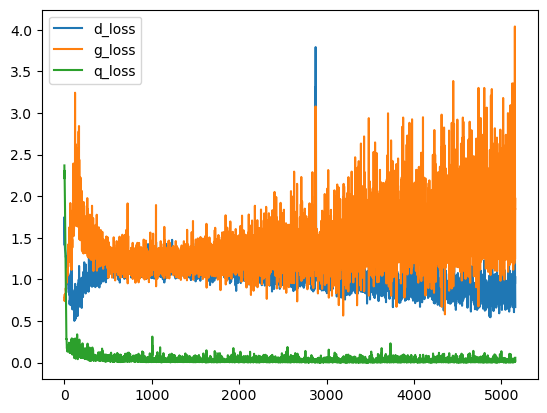

In [13]:
pd.DataFrame(
    {"d_loss": d_losses, "g_loss": g_losses, "q_loss": q_losses}
).plot(kind="line")
plt.show()

In [14]:
samples = []
model.generator.eval()
with torch.no_grad():
    for i in range(10):
        digit_type = (torch.ones(16, dtype=torch.int64) * i).to(model.device)
        torch.manual_seed(1)
        z_c = nn.functional.one_hot(digit_type, 10).view(
            16, -1, 1, 1
        ).to(model.device)
        z_s = torch.randn(16, model.z_s_dim, 1, 1).to(model.device)
        z = torch.cat([z_c, z_s], dim=1)
        xhat = model.generator(z).cpu()
        samples.append(xhat)

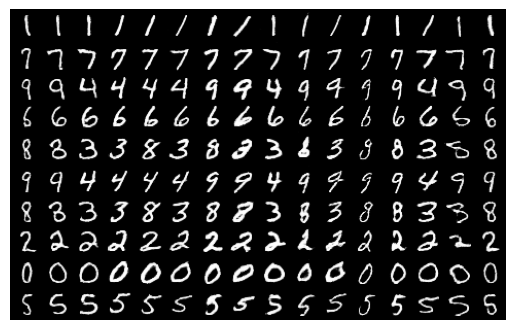

In [15]:
plt.imshow(torch.permute(make_grid(torch.cat(samples, dim=0), nrow=16), (1, 2, 0)))
plt.axis('off')
plt.show()

### CLEARInfoVAE

In [80]:
from src.trainer import CLEARInfoGAN, TestGAN

In [95]:
model = CLEARInfoGAN(
    z_dim=100,
    num_classes=10,
    lr=1e-4,
    hyperparam={"lambda_info": 10, "tau": 0.1},
    verbose_period=2,
    device=device
)

In [96]:
d_losses, g_losses, q_losses = model.fit(11, train_loader)

Epoch 10: 100%|██████████| 469/469 [00:15<00:00, 30.61batch/s, d_loss=1.12, g_loss=1.18, loss_c=4.62e-5, loss_s=0.108, q_loss=0.0198]   


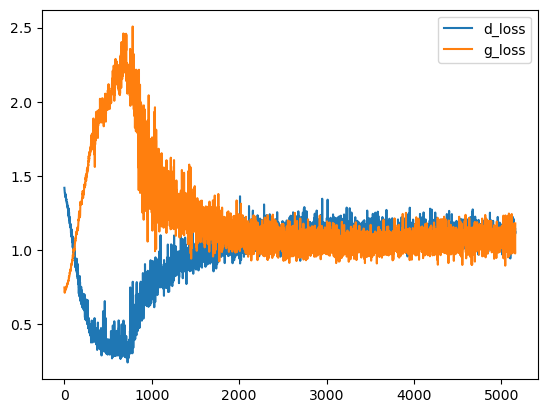

In [97]:
pd.DataFrame(
    {"d_loss": d_losses, "g_loss": g_losses}
).plot(kind="line")
plt.show()

In [98]:
model.generator.eval()
z_cs, z_ss = [], []
labels = []

samples = []
with torch.no_grad():
    for i in range(10):
        digit_type = (torch.ones(16, dtype=torch.int64) * i).to(model.device)
        torch.manual_seed(1)
        z_raw = torch.randn(16, model.z_dim).to(model.device)
        label_onehot = nn.functional.one_hot(digit_type, 10).to(model.device)
        z_c = model.zc_encoder(torch.cat([z_raw, label_onehot], dim=-1))
        z_s = model.zs_encoder(torch.cat([z_raw, label_onehot], dim=-1))
        z = torch.cat([z_c, z_s], dim=1)[:, :, None, None]
        xhat = model.generator(z)
        hidden_hat =  model.encoder(xhat).detach()
        z_c_hat, z_s_hat = model.qhead_c(hidden_hat).squeeze(), model.qhead_s(hidden_hat).squeeze()
        samples.append(xhat.detach().cpu())
        z_cs.append(z_c_hat)
        z_ss.append(z_s_hat)
        labels.append(digit_type)
z_cs, z_ss = torch.cat(z_cs, dim=0), torch.cat(z_ss, dim=0)
labels = torch.cat(labels, dim=0)

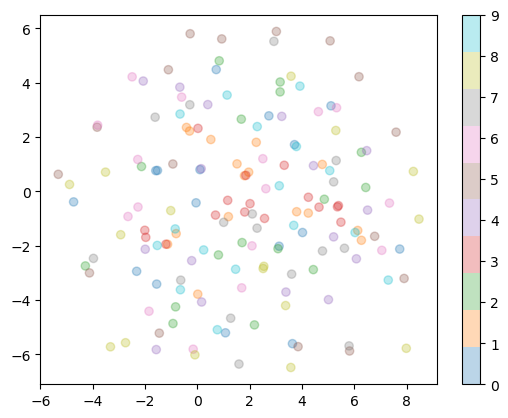

In [102]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
z_cs_tsne = tsne.fit_transform(z_cs.cpu().numpy())
plt.scatter(z_cs_tsne[:, 0], z_cs_tsne[:, 1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='')


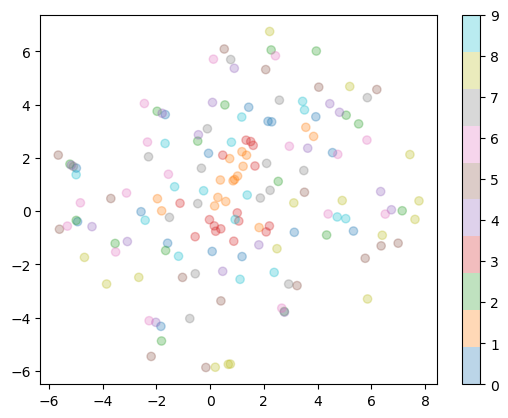

In [101]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
z_ss_tsne = tsne.fit_transform(z_ss.cpu().numpy())
plt.scatter(z_ss_tsne[:, 0], z_ss_tsne[:, 1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='')

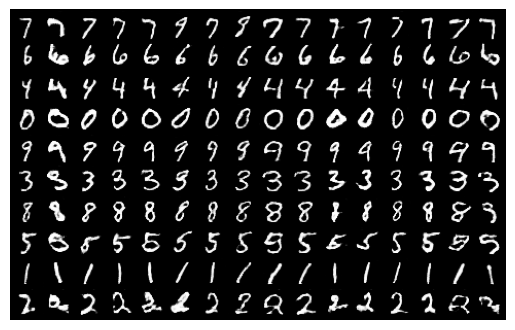

In [100]:
plt.imshow(torch.permute(make_grid(torch.cat(samples, dim=0), nrow=16), (1, 2, 0)))
plt.axis('off')
plt.show()
